In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Visual captioning with Imagen on Vertex AI

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/vision/getting-started/visual_captioning.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/vision/getting-started/visual_captioning.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/blob/main/vision/getting-started/visual_captioning.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>


| | |
|-|-|
|Author(s) | [Thu Ya Kyaw](https://github.com/iamthuya) |

## Overview

[Imagen on Vertex AI](https://cloud.google.com/vertex-ai/docs/generative-ai/image/overview) (image Generative AI) offers a variety of features:
- Image generation
- Image editing
- Visual captioning
- Visual question answering

This notebook focuses on **visual captioning** only.

[Visual captioning with Imagen on Vertex AI](https://cloud.google.com/vertex-ai/docs/generative-ai/image/image-captioning) can generate text descriptions of images. The model takes in an image as input and produces one or more text descriptions of the image as output. The generated text descriptions can be used for a variety of use cases:
- getting detailed metadata about images for storing and searching
- generating automated captioning to support accessibility use cases
- producing descriptions of products and visual assets

More information about Visual captioning with Imagen on  Vertex AI can be found in the [official documentation](https://cloud.google.com/vertex-ai/docs/generative-ai/image/image-captioning).

### Objectives

In this notebook, you will learn how to use the Vertex AI Python SDK to:

- Generate image captions using the Imagen's visual captioning features

- Experiment with different parameters, such as:
    - number of captions to be generated
    - language of the generated captions
    - type and version of model that is used to generate the captions




### Costs

- This notebook uses billable components of Google Cloud:
  - Vertex AI (Imagen)

- Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Getting Started

### Install Vertex AI SDK, other packages and their dependencies

In [1]:
%pip install --upgrade --user google-cloud-aiplatform>=1.29.0

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [2]:
# Restart kernel after installs so that your environment can access the new packages
import IPython
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>

### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, you will need to authenticate your environment. To do this, run the new cell below. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).

In [1]:
import sys

# Addtional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Define Google Cloud project information (Colab only)

If you are running this notebook on Google Colab, you need to define Google Cloud project information to be used. In the following cell, you will define the information, import Vertex AI package, and initialize it. This step is also not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).

In [2]:
if "google.colab" in sys.modules:
    # Define project information
    PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
    LOCATION = "us-central1"  # @param {type:"string"}

    # Initialize Vertex AI
    import vertexai

    vertexai.init(project=PROJECT_ID, location=LOCATION)

### Load the image captioning model

The model names from Vertex AI Imagen have two components: model name and version number. The naming convention follow this format: `<model-name>@<version-number>`. For example, `imagetext@001` represent the version **001** of the **imagetext** model.



In [3]:
from vertexai.preview.vision_models import ImageCaptioningModel

image_captioning_model = ImageCaptioningModel.from_pretrained("imagetext@001")

### Load the image file

To use the visual captioning model, you first need to create an `Image` class using the image file. The model only accepts `Image` class objects, so this is a necessary step before you can generate captions.

Moreover, [Visual Captioning with Imagen](https://cloud.google.com/vertex-ai/docs/generative-ai/image/image-captioning) only accepts specific image file formats (e.g. PNG, JPEG), and may have file size is limitations (e.g. 10 MB). You can find out specific details from [this official documentation](https://cloud.google.com/vertex-ai/docs/generative-ai/image/image-captioning#img-cap-rest).



In [4]:
# Download an image from Google Cloud Storage

! gsutil cp "gs://github-repo/img/vision/google-cloud-next.jpeg" .

Copying gs://github-repo/img/vision/google-cloud-next.jpeg...
/ [1 files][240.3 KiB/240.3 KiB]                                                
Operation completed over 1 objects/240.3 KiB.                                    


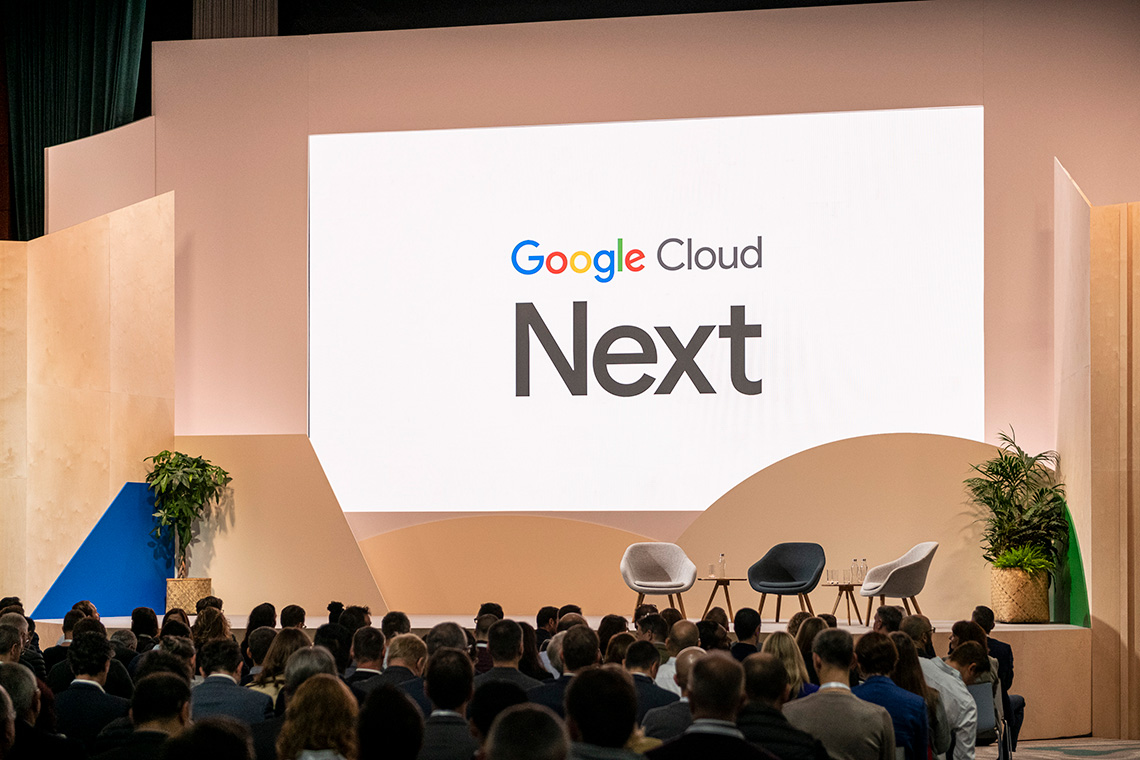

In [5]:
from vertexai.preview.vision_models import Image

# Load the image file as Image object
cloud_next_image = Image.load_from_file("google-cloud-next.jpeg")
cloud_next_image.show()

###  Generate captions from the image

In this section, you will use the visual captioning model to generate text descriptions of an image.

In [6]:
# Get a caption from the image
image_captioning_model.get_captions(
    image=cloud_next_image,
)

['a group of people sitting in front of a google cloud next sign']

You can generate up to three captions from a single image by changing the `number_of_results` parameter from 1 to 3.

In [7]:
# Get 3 captions from the image
image_captioning_model.get_captions(
    image=cloud_next_image,
    number_of_results=3,
)

['a group of people sitting in front of a google cloud next sign',
 'a group of people are sitting in front of a google cloud next sign',
 'a group of people sitting in front of a google cloud next stage']

### Generating captions in non-English languages

Visual captioning with Imagen on Vertex AI can generate captions in multiple languages as well. To generate a caption in a specific language, you can set the `language` parameter as one of the values:
- `en` - English
- `fr` - French
- `de` - German
- `it` - Italian
- `es` - Spanish

For a list of supported languages, check out the [official documentation](https://cloud.google.com/vertex-ai/docs/generative-ai/image/image-captioning#languages).

In [8]:
# Get 3 image captions in French
image_captioning_model.get_captions(
    image=cloud_next_image,
    number_of_results=3,
    language="fr",
)

['un groupe de personnes assises devant un écran qui dit google cloud next',
 'un groupe de personnes assises devant un écran avec le logo google cloud next',
 'un groupe de personnes assises devant un écran avec le mot google cloud next']

## Try it yourself

You can also try using the visual captioning model with images of your choice. If you need to download an image file, you can use the provided auxiliary function `download_image`.

Feel free to experiment with different images and model parameters to see how the results change.

In [9]:
import os
import requests


def download_image(url):
    """Downloads an image from the specified URL."""

    # Send a get request to the url
    response = requests.get(url)

    # If the request is successful
    if response.status_code == 200:
        # Define image related variables
        image_path = os.path.basename(url)
        image_bytes = response.content
        image_type = response.headers["Content-Type"].split("/")[1]

        # Check for image type, currently only PNG or JPEG format are supported
        if image_type in ("png", "jpg", "jpeg"):
            # Write image data to a file
            with open(image_path, "wb") as f:
                f.write(image_bytes)
            return image_path
        else:
            raise Exception("Image can only be in PNG or JPEG format")

    else:
        raise Exception(f"Failed to download image from {url}")

In [10]:
# Download an image
url = "https://storage.googleapis.com/gweb-cloudblog-publish/images/transfor_shared_fate.0999075519991154.max-2000x2000.jpg"
image_path = download_image(url)

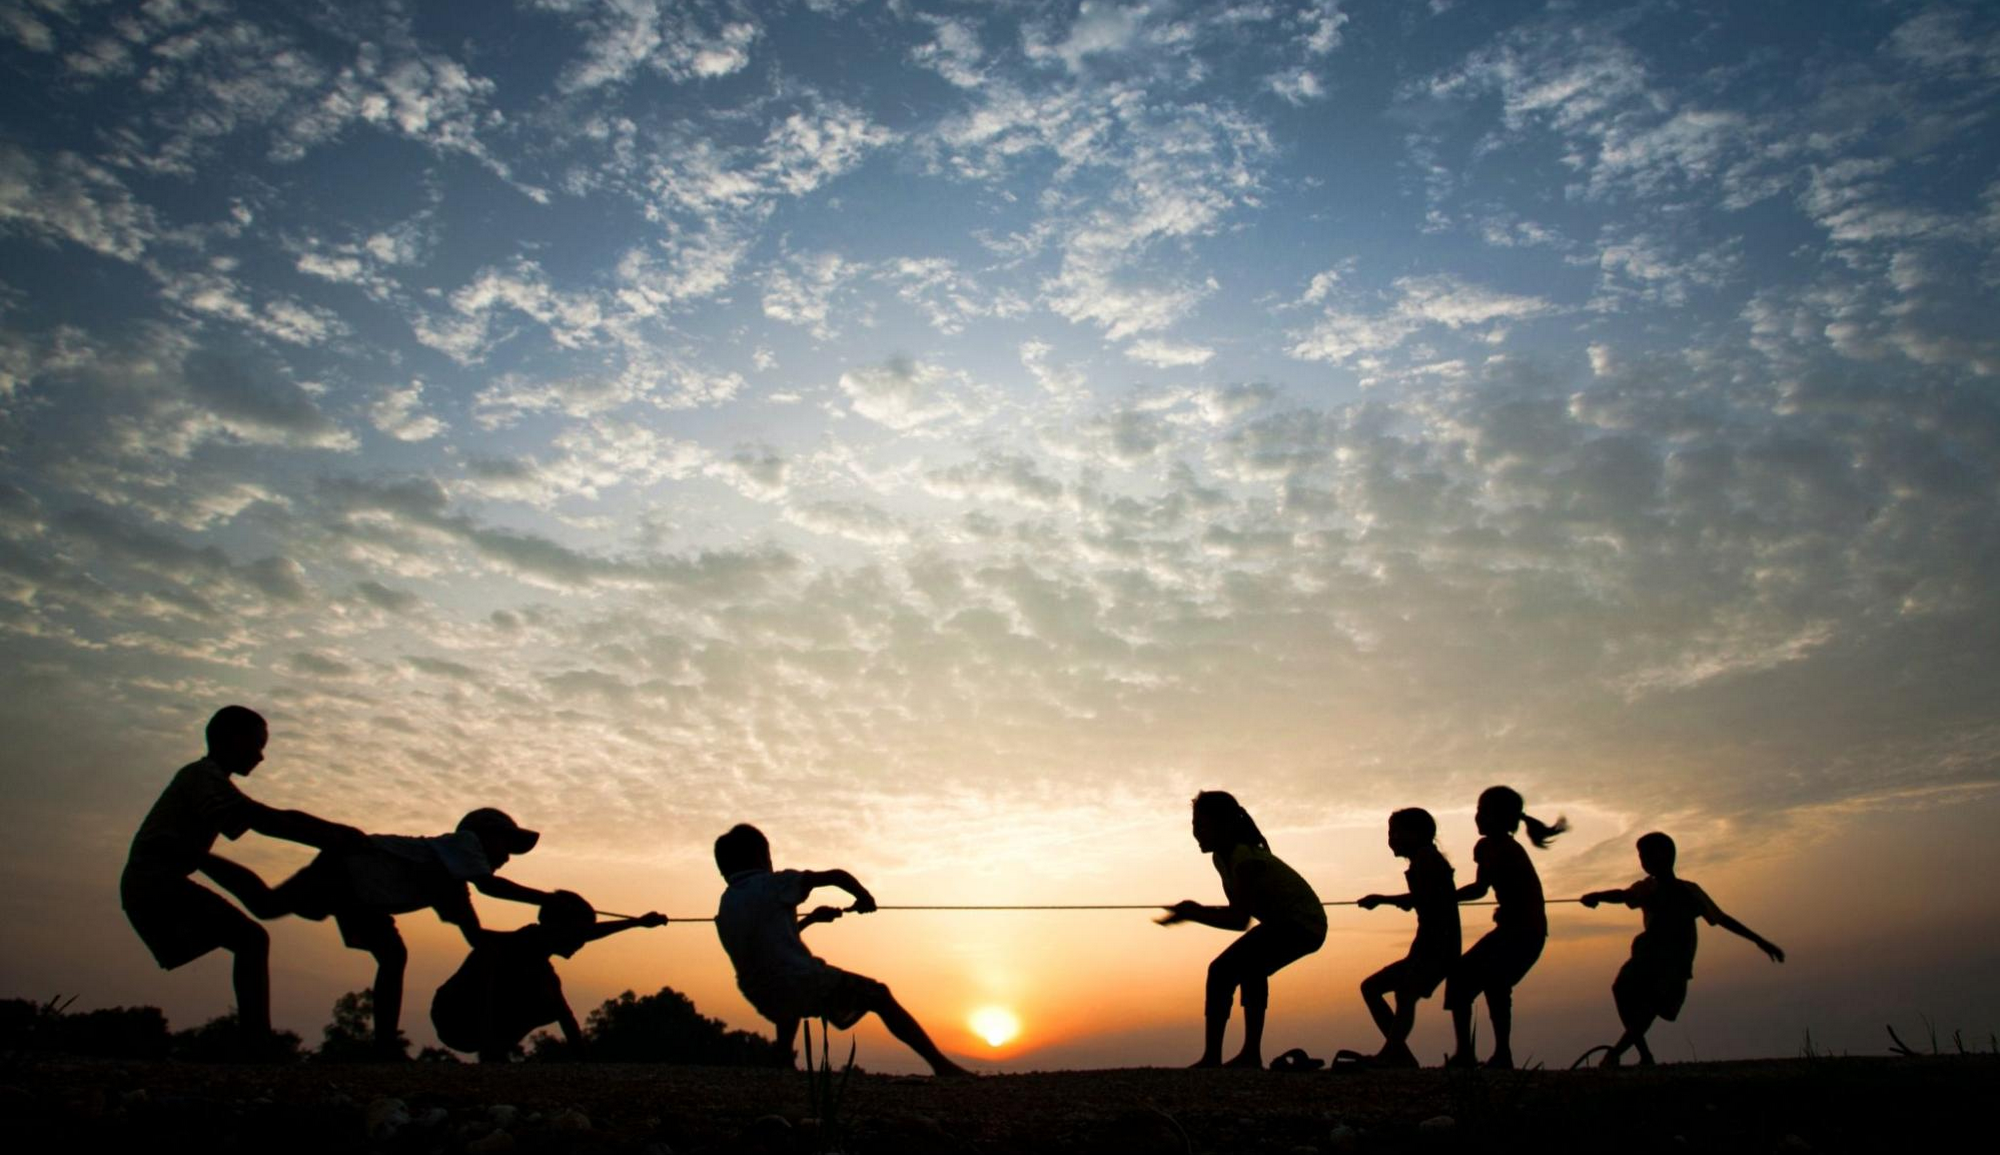

In [11]:
# Load the newly downloaded image
user_image = Image.load_from_file(image_path)
user_image.show()

In [12]:
# Generate the visual captions for the image
image_captioning_model.get_captions(
    image=user_image,
    number_of_results=3,
    language="en",
)

['a group of children are playing tug of war at sunset',
 'a group of kids are playing tug of war at sunset',
 'a group of children are playing tug of war with a sunset in the background']